In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import upsetplot
from dython.nominal import theils_u
import random
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Magda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Magda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
file = "C:/Users/Magda/Documents/detect-toxic-comments/data/train.csv"
df = pd.read_csv(file)

In [18]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [19]:
df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [20]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [21]:
TOXIC_LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
CONTENT_LABEL = "comment_text"
for col in TOXIC_LABELS:
    print("Labels for %s are: %s" % (col, ', '.join(map(str, df[col].unique()))))

Labels for toxic are: 0, 1
Labels for severe_toxic are: 0, 1
Labels for obscene are: 0, 1
Labels for threat are: 0, 1
Labels for insult are: 0, 1
Labels for identity_hate are: 0, 1


In [22]:
INNOCENT_LABEL = "innocent"
df[INNOCENT_LABEL] = (df[TOXIC_LABELS].sum(axis = 1) == 0).astype(int)
LABELS = TOXIC_LABELS + [INNOCENT_LABEL]

In [23]:
# Sample comments
for label in TOXIC_LABELS:
    row2take = random.randint(0, 20)
    comment = df[CONTENT_LABEL][df[label] == 1].iloc[row2take]
    print(label.upper() + ": ")
    print(comment + "\n")

TOXIC: 
Your blatant POV pushing 

Neither of you guys has made any contribution to this Italian history article other than to shove your unhistorical unconstructive modern POV in my face.
This is a HISTORY article. HISTORY.
Have you heard of that?
This is the reason why so many people get pissed off about the pedantry and idiocy and triviality of Wikipedia.
J*sus. Get a f*cking life.

SEVERE_TOXIC: 
closedmouth is a DICK-FUCK 

this guy is a jackass who sux cock 4 a fuckin job y the fuck does the trans do it?????cuz its into tht kinda shit >:(

OBSCENE: 
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie

THREAT: 
Hi! I am back again!
Last warning!
Stop undoing my edits or die!

INSULT: 
this user is such a worthless goddamn faggot fuck you faggot

IDENTITY_HATE: 
YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

I fucked your

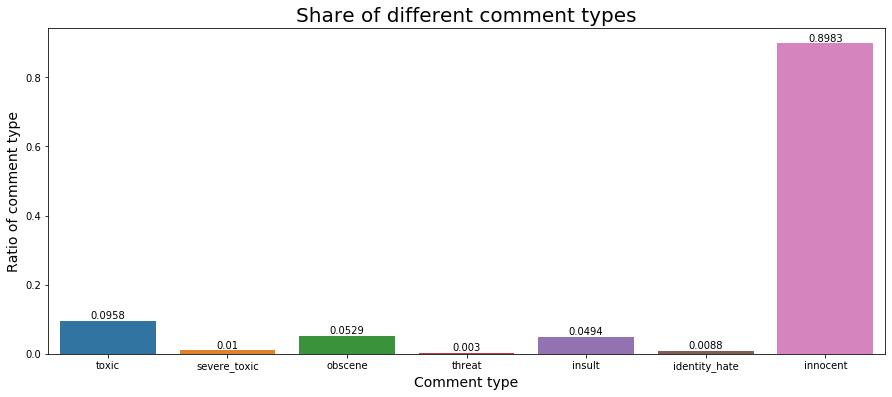

In [24]:
# Analyse share of each label

plt.figure(figsize=(15,6))
ratio = df[LABELS].mean()
PRECISION = 1e4
ax = sns.barplot(LABELS, ratio)

plt.title("Share of different comment types", fontsize = 20)
plt.xlabel("Comment type", fontsize = 14)
plt.ylabel("Ratio of comment type", fontsize = 14)

for bar, val in zip(ax.patches, ratio):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), round(val*PRECISION)/PRECISION, ha='center', va='bottom')
    
plt.show()

There are 159571 comments, but 178444 comment labels.


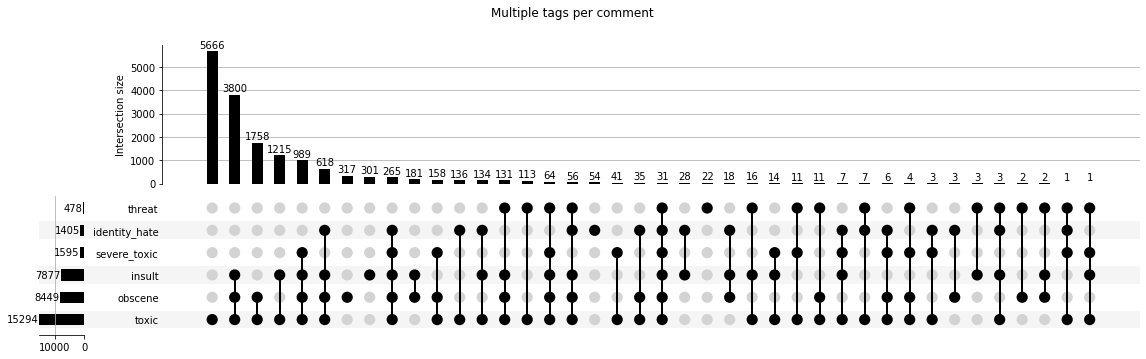

In [25]:
# Multiple labels
print("There are %s comments, but %s comment labels." % (df.shape[0], int(df.shape[0]*ratio.sum())))

UNIQUE_ID = "id"
df_subset = df[TOXIC_LABELS + [UNIQUE_ID]].loc[df[INNOCENT_LABEL] == 0]
counts = df_subset.astype(bool).groupby(TOXIC_LABELS).count()[UNIQUE_ID]
upsetplot.plot(counts, subset_size='sum', show_counts = "%d", sort_by = 'cardinality')
plt.suptitle('Multiple tags per comment')
plt.show()

In [26]:
# Theil's U uncertanity coefficient 
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
uncertanity_coeff = [[0]*len(TOXIC_LABELS) for label in TOXIC_LABELS]

for label_1 in range(len(TOXIC_LABELS)):
    for label_2 in range(len(TOXIC_LABELS)):
        uncertanity_coeff[label_1][label_2] = theils_u(df[TOXIC_LABELS[label_1]], df[TOXIC_LABELS[label_2]])

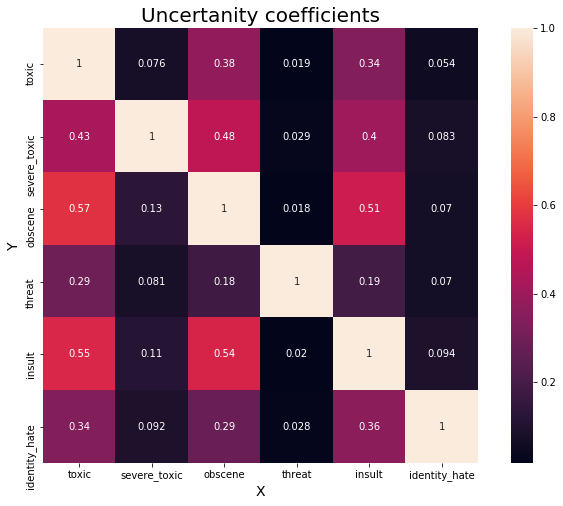

In [27]:
# Interpretation: Certanity that knowing Y we know X, but not vice-versa.

plt.figure(figsize=(12,8))
ax = sns.heatmap(uncertanity_coeff,annot=True, xticklabels=TOXIC_LABELS,
            yticklabels=TOXIC_LABELS, square=True)
plt.title("Uncertanity coefficients", fontsize = 20)
plt.xlabel("X", fontsize = 14)
plt.ylabel("Y", fontsize = 14)
plt.show()

In [33]:
# Clean text corpus
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import re

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
porter = PorterStemmer()

In [34]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [77]:
def custom_preprocess(comment):
    
    # Cleaning:
    # 1. Lowercase
    # 2. Remove /n
    # 3. Detect IP
    # 4. Detect links
    # 5. Remove apostrophes
    
    IP_TOKEN ="IP"
    URL_TOKEN = "URL"
    
    comment = comment.lower()
    comment = re.sub("\\n","",comment)     #remove \n

    words = comment.split()
    for idx in range(len(words)):
        
        if words[idx] in APPO:
            words[idx] = APPO[words[idx]]
        elif re.search("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", words[idx]):
            words[idx] = IP_TOKEN
        elif re.search("http://.*com", words[idx]):
            words[idx] = URL_TOKEN              
    
    comment = ' '.join(words)
    
    return comment


def custom_tokenize(comment):
    
    DIGIT_TOKEN = "DIGIT"
    ORDER_TOKEN = "ORDER"
    SPAM_TOKEN = "SPAM"
    YEAR_TOKEN = "YEAR"
    SPAM_CHAR_LIMIT = 50 # Longest english word: 45 chars (pneumonoultramicroscopicsilicovolcanoconiosis)
    words = tokenizer.tokenize(comment)
    
    for idx in range(len(words)):
        
        if re.search('\d[19|20]\d{2}s?', words[idx]):
            words[idx] = YEAR_TOKEN
        elif words[idx].isdigit():
            words[idx] = DIGIT_TOKEN
        elif re.search("\d+(?:st|nd|rd|th)", words[idx]):
            words[idx] = ORDER_TOKEN
        else:    
            if len(words[idx]) > SPAM_CHAR_LIMIT:
                words[idx] = SPAM_TOKEN
            else:
                lemmatizer.lemmatize(words[idx], "v")
                porter.stem(words[idx])
            
    return words
 

In [78]:
# Model: TF-IDF (Term Frequency - Inverse Document Frequency) 

df[CONTENT_LABEL].fillna("unknown", inplace=True)

tfv = TfidfVectorizer(ngram_range=(1, 1),
                     tokenizer=custom_tokenize,
                     preprocessor = custom_preprocess,
                     strip_accents='unicode', 
                     stop_words = 'english',
                     analyzer='word',
                     max_features = 10000,
                     min_df=1)

In [79]:
trn_term_doc = tfv.fit_transform(df[CONTENT_LABEL])

In [80]:
features = np.array(tfv.get_feature_names())
for feature in features:
    print(feature)

0
00
000
01
02
03
04
05
06
07
08
09
0px
1
10
100
101
11
12
13
14
15
150
16
17
18
19
1em
1lol
1px
1r
1rr
2
20
200
21
22
23
24
248
25
250
26
27
27_noticeboard
28
29
3
30
300
31
32
33
34
35
36
37
38
39
3d
3rr
4
40
400
41
42
43
44
45
46
47
48
49
4chan
5
50
500
51
52
53
54
55
56
57
58
59
5mm
6
60
600
60s
62
64
65
66
67
678
68
69
7
70
700
70s
71
72
73
74
75
76
78
7e
8
80
800
80s
81
85
87
88
8px
9
90
90s
91
92
95
96
97
978
98
99
999
DIGIT
I
IP
ORDER
SPAM
URL
YEAR
_
__
a1
a7
aa
aaron
ab
abandon
abandoned
abbreviation
abbreviations
abc
abdul
abide
abilities
ability
able
abortion
abraham
abroad
absence
absent
absolute
absolutely
abstract
absurd
abu
abuse
abused
abuses
abusing
abusive
ac
academia
academic
academics
academy
acceleration
accent
accents
accept
acceptable
acceptance
accepted
accepting
accepts
access
accessed
accessible
accident
accidental
accidentally
accidents
accommodate
accompanied
accomplish
accomplished
accomplishments
accord
accordance
according
accordingly
account
accountable


exhibit
exhibition
exile
exist
existance
existed
existence
existent
existing
exists
exit
exodus
expand
expanded
expanding
expansion
expect
expectations
expected
expecting
expedition
expelled
expense
expensive
experience
experienced
experiences
experiment
experimental
experimenting
experiments
expert
expertise
experts
expire
expired
expires
explain
explained
explaining
explains
explanation
explanations
explanatory
explicit
explicitly
explore
explorer
explosion
expose
exposed
exposing
exposure
express
expressed
expressing
expression
expressions
extend
extended
extending
extension
extensive
extensively
extent
external
extinct
extinction
extra
extract
extraordinary
extreme
extremely
extremist
extremists
eye
eyed
eyes
f
f1
f5fffa
fa
fabricated
fabrication
fac
face
facebook
faced
faces
facilitate
facilities
facility
facing
facist
fack
fact
facto
factor
factors
factory
facts
factual
factually
faculty
fag
faggot
faggots
faggotthanks
fags
fail
failed
failepic
failing
fails
failure
failures
fair

posters
posting
postings
posts
pot
potato
potential
potentially
potter
pound
pounds
pour
pov
poverty
povs
power
powerful
powerproof
powers
pp
ppl
pr
practical
practically
practice
practiced
practices
practicing
practitioners
pradesh
praise
praised
pray
prayer
prc
pre
preceded
precedence
precedent
preceding
precious
precise
precisely
precision
predict
predicted
prediction
predictions
predominantly
prefer
preferable
preferably
preference
preferences
preferred
prefers
pregnancy
pregnant
prejudice
premature
premier
premise
preparation
prepare
prepared
preparing
presence
present
presentation
presented
presenting
presently
presents
preserve
preserved
preserving
presidency
president
presidential
presidents
press
pressed
pressing
pressure
prestige
prestigious
presumably
presume
presumed
pretend
pretending
pretext
pretty
prev
prevail
prevalent
prevent
prevented
preventing
prevention
prevents
preview
previous
previously
price
prices
prick
prickfire
pride
priest
priests
primarily
primary
prime
pr

{'but', "wasn't", 'such', "it's", 'this', 'myself', 'that', "haven't", 'yourself', 'mightn', 'i', 'before', "don't", 'than', 'mustn', 'there', 'wasn', 'why', "aren't", 'over', 'will', "weren't", 'above', 'to', 'yourselves', "hadn't", 'whom', 're', 'do', 'again', 'other', "didn't", 'which', 'nor', 'from', 'until', 'through', 'ain', "wouldn't", 'our', "couldn't", 'my', 'ourselves', 'after', 'doesn', 'hadn', 'doing', 'who', 'only', 'had', 'and', 'can', 'weren', 'has', 'her', 'up', 'they', 'his', 'here', 'because', "you'd", 'where', 'a', 'their', "you're", 'under', 'hasn', 's', 'on', "that'll", "hasn't", 'was', 'out', 'into', "you've", 'them', 'its', 'am', 'about', 'each', 'him', "needn't", 'y', 'while', 'below', 'we', "doesn't", 'shan', 'same', 'these', 'for', 'how', 'against', 'of', 'aren', 'be', 'd', 'when', 'me', 'now', 've', 'm', 'if', 'ours', 'as', "shan't", 'what', 'couldn', "shouldn't", 'been', 'all', 'should', 'most', 'needn', 'at', 'is', 'have', 'very', 'were', 'herself', 'any', 